# Header

* set up the Python environment and load some helper functions

In [1]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import missingno as msno
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
from collections import Counter

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.1f}'.format


%matplotlib inline

/Users/scheckley/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/scheckley/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/scheckley/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## task 1 - data analysis

## Data import and cleaning

In [2]:
data = pd.read_csv('./data.csv',encoding='ISO-8859-1')

In [3]:
data.shape

(541909, 8)

The data consists of 8 columns and 541909 rows.

In [4]:
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.5,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.4,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.8,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.4,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.4,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.7,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.2,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.9,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.9,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.7,13047.0,United Kingdom


A cursory check for missing data:

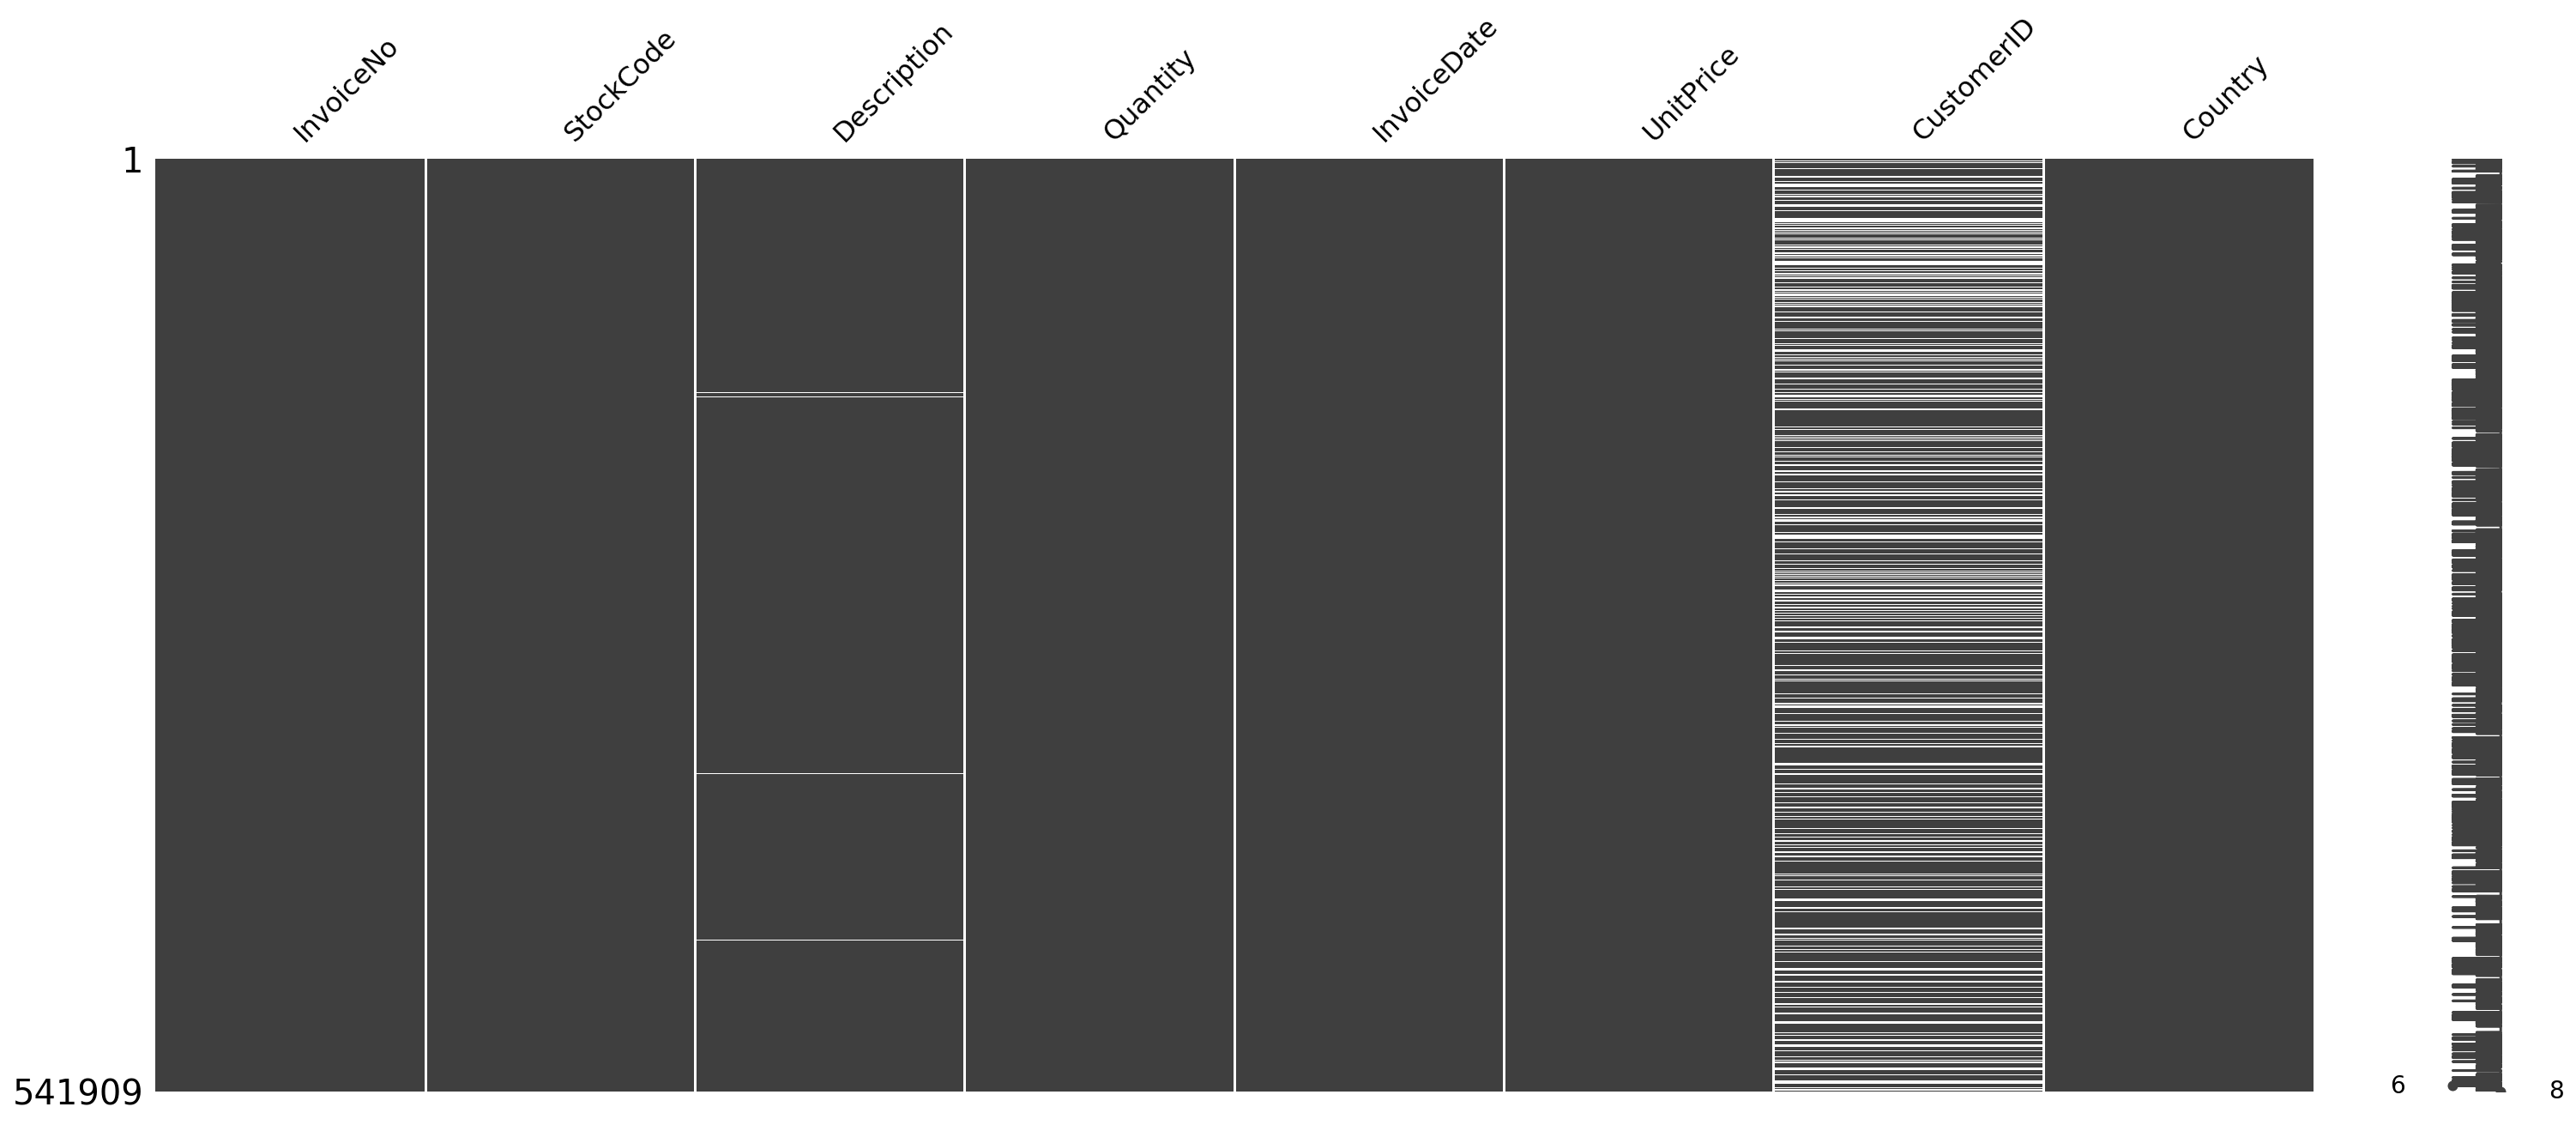

In [5]:
msno.matrix(data);

The dataset is missing some Description and customer ID data entries.

In [6]:
null_data = data[data.isnull().any(axis=1)]
null_data.shape

(135080, 8)

In [7]:
null_data_frac = null_data.shape[0]/data.shape[0]*100
null_data_frac

24.926694334288598

25% of the data contains missing values, which the figure above indicates is mostly nan values in CustomerID

## Exploratory data analysis

In [8]:
data = data.sort_values('Quantity', ascending=False)
data.head(11)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom
74614,542504,37413,NaN,5568,1/28/2011 12:03,0.0,nan,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom
220843,556231,85123A,?,4000,6/9/2011 15:04,0.0,nan,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2/22/2011 10:43,0.8,18087.0,United Kingdom
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,7/19/2011 17:04,0.1,14609.0,United Kingdom
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,4/18/2011 13:20,2.1,15749.0,United Kingdom


The top 10 most popular items are sold in/to the UK. Apparently paper craft little birdie is very popular, along with medium ceramic top storage jar. I will remove the items with 'NaN' descriptor. These entries associated with nan CustomerID entries and 131 lower case descriptions which describe problems with the orders and no details of the item ordered. In addition, the data for United Kingdom contains negative values associated with negative UnitPrice values. Removing the rows containing NaN values therefore cleans several issues that complicate this analysis in the absence of the data owner.

In [9]:
data = data.dropna()

In [10]:
data.shape # 541909 - 406829 = dropped 135,080 entries

(406829, 8)

In [11]:
# in addition I will check for duplicate entries and remove those
data.drop_duplicates(inplace = True)

In [12]:
data.shape

(401604, 8)

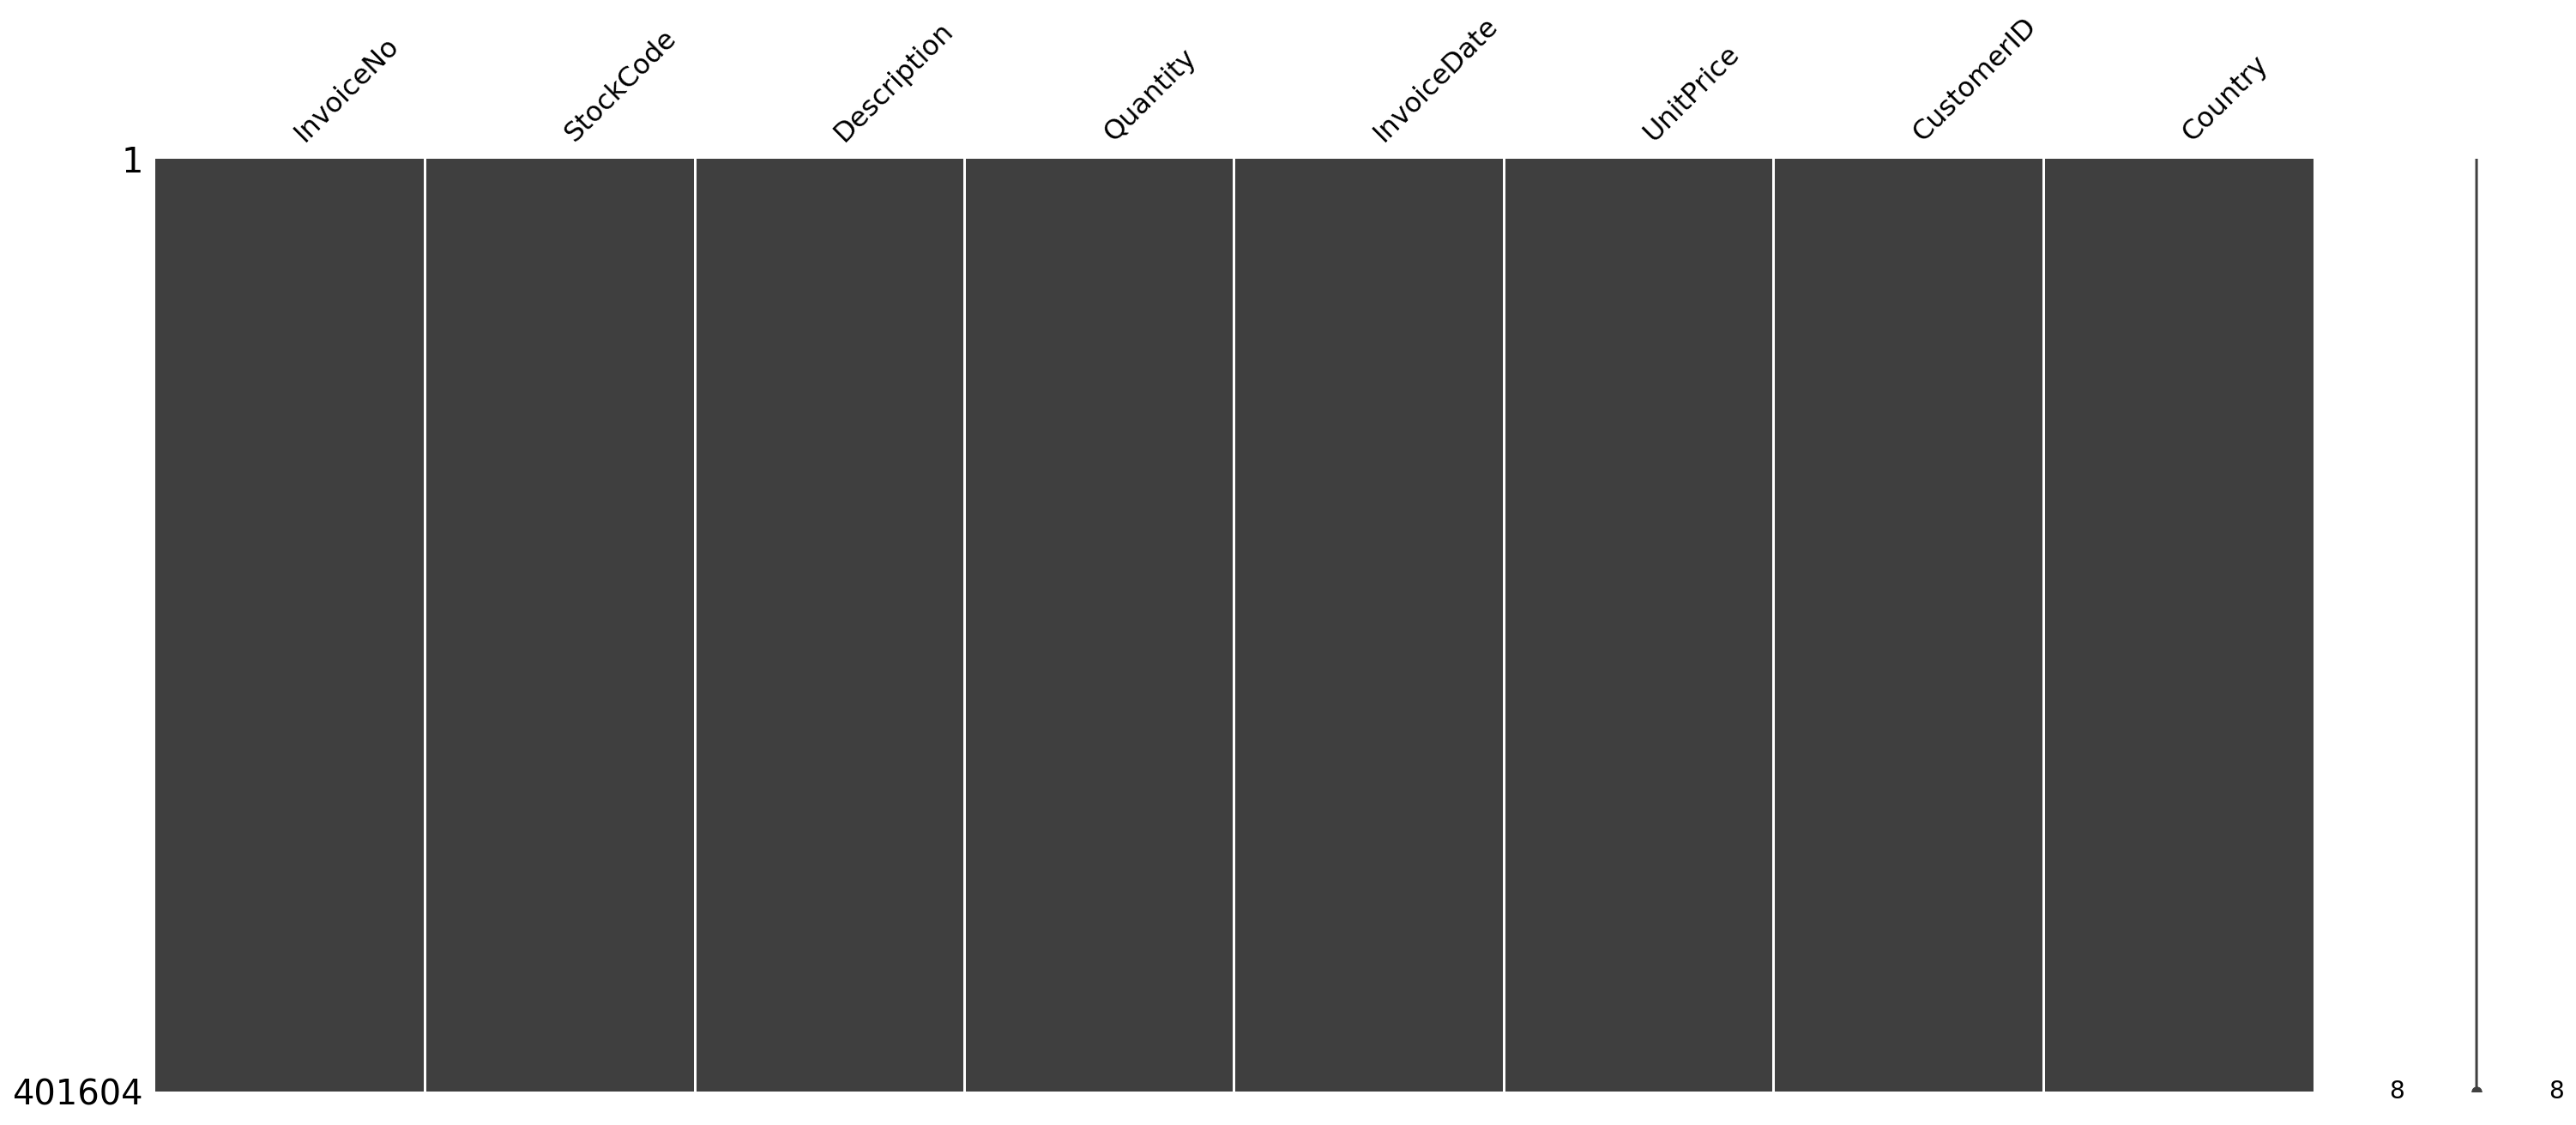

In [13]:
msno.matrix(data);

We now have no missing values and have removed assumed erroneous results and duplicates.

### Further exploration

How many unique descriptors are there in "Descriptions"?

In [14]:
# general clean up of Description column to remove any heading or trailing white space
data['Description'] = data['Description'].str.strip()
descriptors = pd.unique(data['Description'].values.ravel()).tolist()
print('There are',len(descriptors), 'unique descriptors in the Descriptions column.')

There are 3885 unique descriptors in the Descriptions column.


In [15]:
descriptors2 = []
for i in range(0,len(descriptors),1):
    text = str(descriptors[i])
    if text == text.upper():
        descriptors2.append(text)
        
print('There are', len(descriptors2), 'all caps descriptors.')

There are 3862 all caps descriptors.


In [16]:
descriptors2

['PAPER CRAFT , LITTLE BIRDIE',
 'MEDIUM CERAMIC TOP STORAGE JAR',
 'ASSTD DESIGN 3D PAPER STICKERS',
 'WORLD WAR 2 GLIDERS ASSTD DESIGNS',
 'SMALL POPCORN HOLDER',
 'EMPIRE DESIGN ROSETTE',
 'FAIRY CAKE FLANNEL ASSORTED COLOUR',
 'SMALL CHINESE STYLE SCISSOR',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'PACK OF 60 PINK PAISLEY CAKE CASES',
 'GROW A FLYTRAP OR SUNFLOWER IN TIN',
 'RABBIT NIGHT LIGHT',
 'PACK OF 12 SKULL TISSUES',
 'RED  HARMONICA IN BOX',
 'GIN + TONIC DIET METAL SIGN',
 'POPCORN HOLDER',
 'PINK VINTAGE SPOT BEAKER',
 'GREEN VINTAGE SPOT BEAKER',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'BLUE VINTAGE SPOT BEAKER',
 'ASSORTED COLOUR T-LIGHT HOLDER',
 'RAIN PONCHO RETROSPOT',
 'GINGHAM HEART DECORATION',
 'ASSORTED LAQUERED INCENSE HOLDERS',
 'LETTER SHAPE PENCIL SHARPENER',
 'HERB MARKER BASIL',
 'VINTAGE DOILY JUMBO BAG RED',
 'ROUND SNACK BOXES SET OF 4 FRUITS',
 'GIRLS ALPHABET IRON ON PATCHES',
 'ASSORTED INCENSE PACK',
 'PACK OF 72 RETROSPOT CAKE CASES',
 '72 SWEETHEART FAI

In [17]:
# from inspection of the baskets below I identified 3 problem descriptors that need to be followed up.
additional_problem_list = ['damages/credits from ASOS.','incorrectly credited C550456 see 47', 'mystery! Only ever imported 1800']

In [18]:
# remove additional erroneous rows
data = data[~data['Description'].isin(additional_problem_list)]

In [19]:
data.shape

(401604, 8)

In [20]:
InvoiceNo = pd.unique(data['InvoiceNo'].values.ravel()).tolist()
print('There are', len(InvoiceNo), 'unique invoice numbers in the dataset.')

There are 22190 unique invoice numbers in the dataset.


#### Group my country

In [21]:
by_country = data.groupby('Country')
by_country.describe()

CustomerID                                         \
                          count    mean    std     min     25%     50%   
Country                                                                  
Australia                1258.0 12464.7  438.0 12386.0 12415.0 12415.0   
Austria                   401.0 12521.5  216.5 12358.0 12360.0 12374.0   
Bahrain                    17.0 12354.5    0.9 12353.0 12355.0 12355.0   
Belgium                  2069.0 12430.3  110.0 12361.0 12383.0 12407.0   
Brazil                     32.0 12769.0    0.0 12769.0 12769.0 12769.0   
Canada                    151.0 17321.1  521.5 15388.0 17444.0 17444.0   
Channel Islands           757.0 14888.1  142.8 14442.0 14930.0 14936.0   
Cyprus                    611.0 12405.4  200.6 12359.0 12359.0 12370.0   
Czech Republic             30.0 12781.0    0.0 12781.0 12781.0 12781.0   
Denmark                   389.0 12536.6  421.9 12367.0 12406.0 12412.0   
EIRE                     7475.0 14748.7  314.5 14016.0 14911.0 14911.0   
European Community         61.0 15108.0    0.0 15108.0 15108.0 15108.0   
Finland                   695.0 12517.0  122.4 12348.0 12428.0 12428.0   
France                   8475.0 12677.5  275.4 12413.0 12571.0 12674.0   
Germany                  9480.0 12645.8  307.9 12426.0 12480.0 12592.0   
Greece                    146.0 13757.4 1749.6 12478.0 12717.0 12717.0   
Iceland                   182.0 12347.0    0.0 12347.0 12347.0 12347.0   
Israel                    247.0 12659.6   57.6 12512.0 12653.0 12688.0   
Italy                     803.0 12648.4  437.4 12349.0 12578.0 12584.0   
Japan                     358.0 12757.8   13.6 12753.0 12753.0 12753.0   
Lebanon                    45.0 12764.0    0.0 12764.0 12764.0 12764.0   
Lithuania                  35.0 15332.0    0.0 15332.0 15332.0 15332.0   
Malta                     127.0 16996.0 1127.5 15480.0 15480.0 17828.0   
Netherlands              2371.0 14420.3  609.5 12759.0 14646.0 14646.0   
Norway                   1086.0 12438.0   76.7 12350.0 12432.0 12433.0   
Poland                    341.0 12733.1   94.9 12576.0 12576.0 12779.0   
Portugal                 1471.0 12746.4   97.3 12356.0 12757.0 12766.0   
RSA                        58.0 12446.0    0.0 12446.0 12446.0 12446.0   
Saudi Arabia               10.0 12565.0    0.0 12565.0 12565.0 12565.0   
Singapore                 229.0 12744.0    0.0 12744.0 12744.0 12744.0   
Spain                    2528.0 12906.1 1272.4 12354.0 12484.0 12540.0   
Sweden                    461.0 14701.4 2379.8 12483.0 12638.0 12697.0   
Switzerland              1877.0 12667.0  460.8 12357.0 12378.0 12451.0   
USA                       291.0 12618.9   38.5 12558.0 12607.0 12607.0   
United Arab Emirates       68.0 14984.6 2546.1 12739.0 12739.0 12739.0   
United Kingdom         356728.0 15543.8 1594.3 12346.0 14191.0 15513.0   
Unspecified               241.0 13733.7 1520.9 12363.0 12743.0 12743.0   

                                     Quantity                                 \
                         75%     max    count mean   std      min   25%  50%   
Country                                                                        
Australia            12415.0 16321.0   1258.0 66.5  97.7   -120.0   6.0 24.0   
Austria              12818.0 12865.0    401.0 12.0  21.7    -48.0   6.0  9.0   
Bahrain              12355.0 12355.0     17.0 15.3  25.0      2.0   6.0  6.0   
Belgium              12431.0 12876.0   2069.0 11.2  13.6    -12.0   4.0 10.0   
Brazil               12769.0 12769.0     32.0 11.1   8.5      2.0   3.0 10.0   
Canada               17444.0 17844.0    151.0 18.3  46.7      1.0   6.0 12.0   
Channel Islands      14936.0 14937.0    757.0 12.5  22.6     -2.0   4.0 10.0   
Cyprus               12391.0 13809.0    611.0 10.3  23.4    -33.0   2.0  5.0   
Czech Republic       12781.0 12781.0     30.0 19.7  22.8    -24.0  12.0 24.0   
Denmark              12429.0 13919.0    389.0 21.0  27.4    -25.0  12.0 12.0   
EIRE                

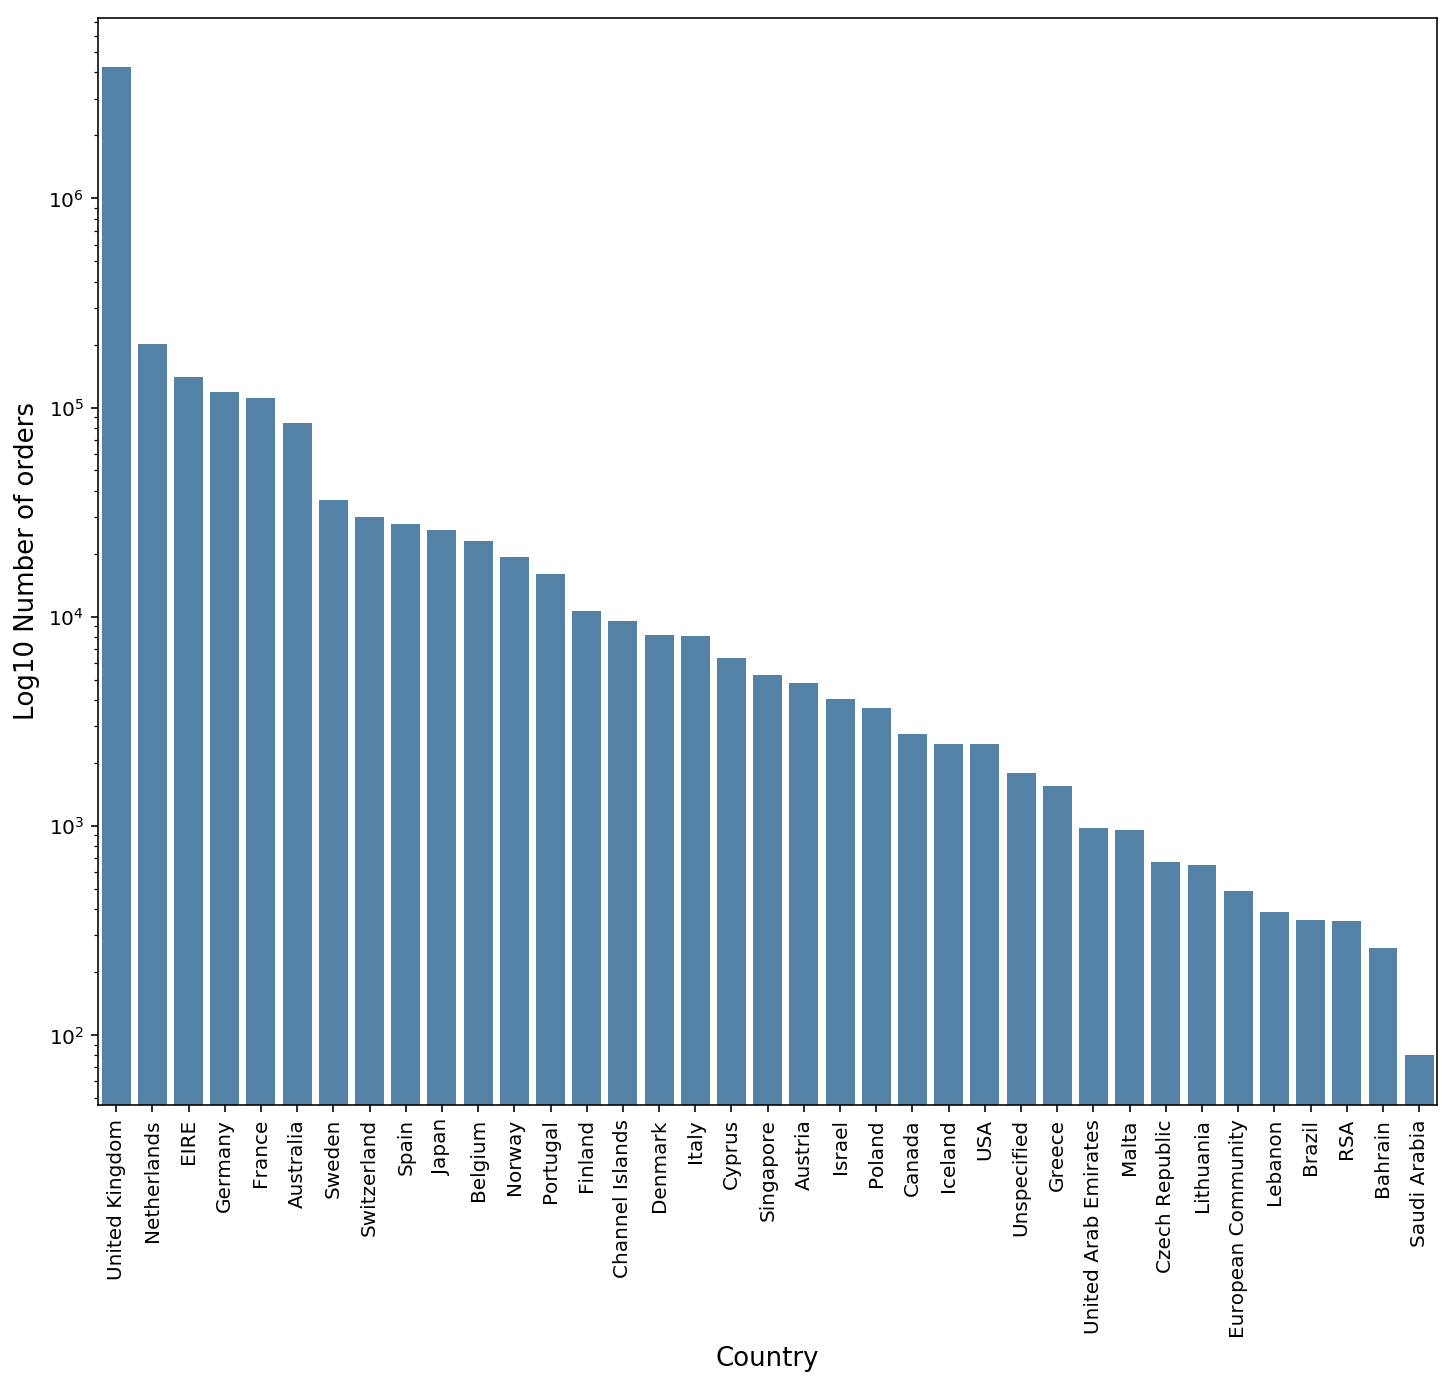

In [96]:
grouped  = data.groupby(['Country']).sum()['Quantity'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color='steelblue')
f.get_axes()[0].set_yscale('log') #I'm using a log scale just for visualisation as the UK dominates the market
plt.ylabel('Log10 Number of orders', fontsize=13)
plt.xlabel('Country', fontsize=13)
plt.show()

The United Kingdom purchases the majority of products by almost 2 orders of magnitude.

In [23]:
# group by customer ID and invoice number to create a basket per customer
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
products_per_basket[:10].sort_values('Number of products', ascending=False)

,CustomerID,InvoiceNo,Number of products
7,12347.0,573511,47
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
6,12347.0,562032,22
5,12347.0,556201,18
9,12348.0,539318,17
8,12347.0,581180,11
0,12346.0,541431,1
1,12346.0,C541433,1


There are InvoiceNo entries beginning with the character C.

In [24]:
print('There are:',data['InvoiceNo'].str.contains("C").sum(), 'orders marked C, which contribute',(data['InvoiceNo'].str.contains("C").sum()/len(data))*100, '% of the dataset.')

There are: 8872 orders marked C, which contribute 2.209141343213713 % of the dataset.


In [25]:
# select all the cancelled orders
cancelled_orders = data[data.InvoiceNo.str.contains("C")]
cancelled_orders.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
268308,C560408,M,Manual,-1,7/18/2011 14:24,550.6,13564.0,United Kingdom
186013,C552841,22838,3 TIER CAKE TIN RED AND CREAM,-1,5/11/2011 14:28,14.9,15827.0,United Kingdom
169480,C551175,22325,MOBILE VINTAGE HEARTS,-1,4/26/2011 17:17,5.0,14329.0,United Kingdom
429996,C573575,CRUK,CRUK Commission,-1,10/31/2011 14:09,606.0,14096.0,United Kingdom
281674,C561591,22768,FAMILY PHOTO FRAME CORNICE,-1,7/28/2011 11:17,9.9,15708.0,United Kingdom
268312,C560409,84078A,SET/4 WHITE RETRO STORAGE CUBES,-1,7/18/2011 14:24,40.0,16717.0,United Kingdom
355585,C567947,23234,BISCUIT TIN VINTAGE CHRISTMAS,-1,9/23/2011 8:00,2.9,17663.0,United Kingdom
355584,C567947,21201,TROPICAL HONEYCOMB PAPER GARLAND,-1,9/23/2011 8:00,2.5,17663.0,United Kingdom
96677,C544577,M,Manual,-1,2/21/2011 14:02,320.7,12365.0,Cyprus
45144,C540250,21928,JUMBO BAG SCANDINAVIAN PAISLEY,-1,1/5/2011 16:02,1.6,17511.0,United Kingdom


InvoiceNo containing a "C" character correspond with a negative Quantity value, therefore I will assume these are cancelled orders. For the purposes of this report I am going to remove cancelled orders from consideration.

In [26]:
data = data[~data['InvoiceNo'].str.contains("C")]

### Investigation of StockCode

There are some non-integer values in StockCodes which correspond with order descriptions that are not items.

In [27]:
mask = (~data['StockCode'].str.contains('[0-9]'))
odd_stock_codes = data.loc[mask] #filter out any stock codes that are numeric to leave the non-standard codes
odd_stock_codes.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
490502,578060,M,Manual,1600,11/22/2011 15:22,0.2,17857.0,United Kingdom
452218,575328,M,Manual,1200,11/9/2011 13:48,0.2,17857.0,United Kingdom
437235,574277,M,Manual,832,11/3/2011 14:42,0.2,17857.0,United Kingdom
526018,580646,M,Manual,800,12/5/2011 13:13,0.2,17857.0,United Kingdom
414138,572344,M,Manual,456,10/24/2011 10:43,1.5,14607.0,United Kingdom


In [28]:
odd_stock_codes['StockCode'].unique(), print('total number of these short stock code entries:',len(odd_stock_codes))

total number of these short stock code entries: 1416


(array(['M', 'POST', 'DOT', 'BANK CHARGES', 'PADS'], dtype=object), None)

As the number of non-standard stock codes is small, for the purposes of this report they will be deleted from the dataset.

In [29]:
data = data.loc[~mask]

During the data cleaning process NaN, duplicate entries, cancelled invoices, and miscellaneous stock codes have been removed.

## Feature engineering

In [30]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom


In [31]:
total_spend = data['Quantity'] * data['UnitPrice']

In [32]:
data = data.assign(total_spend=total_spend.values)

In [33]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,77183.6
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256.0,United Kingdom,0.0
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,1008.0
206121,554868,22197,SMALL POPCORN HOLDER,4300,5/27/2011 10:52,0.7,13135.0,United Kingdom,3096.0


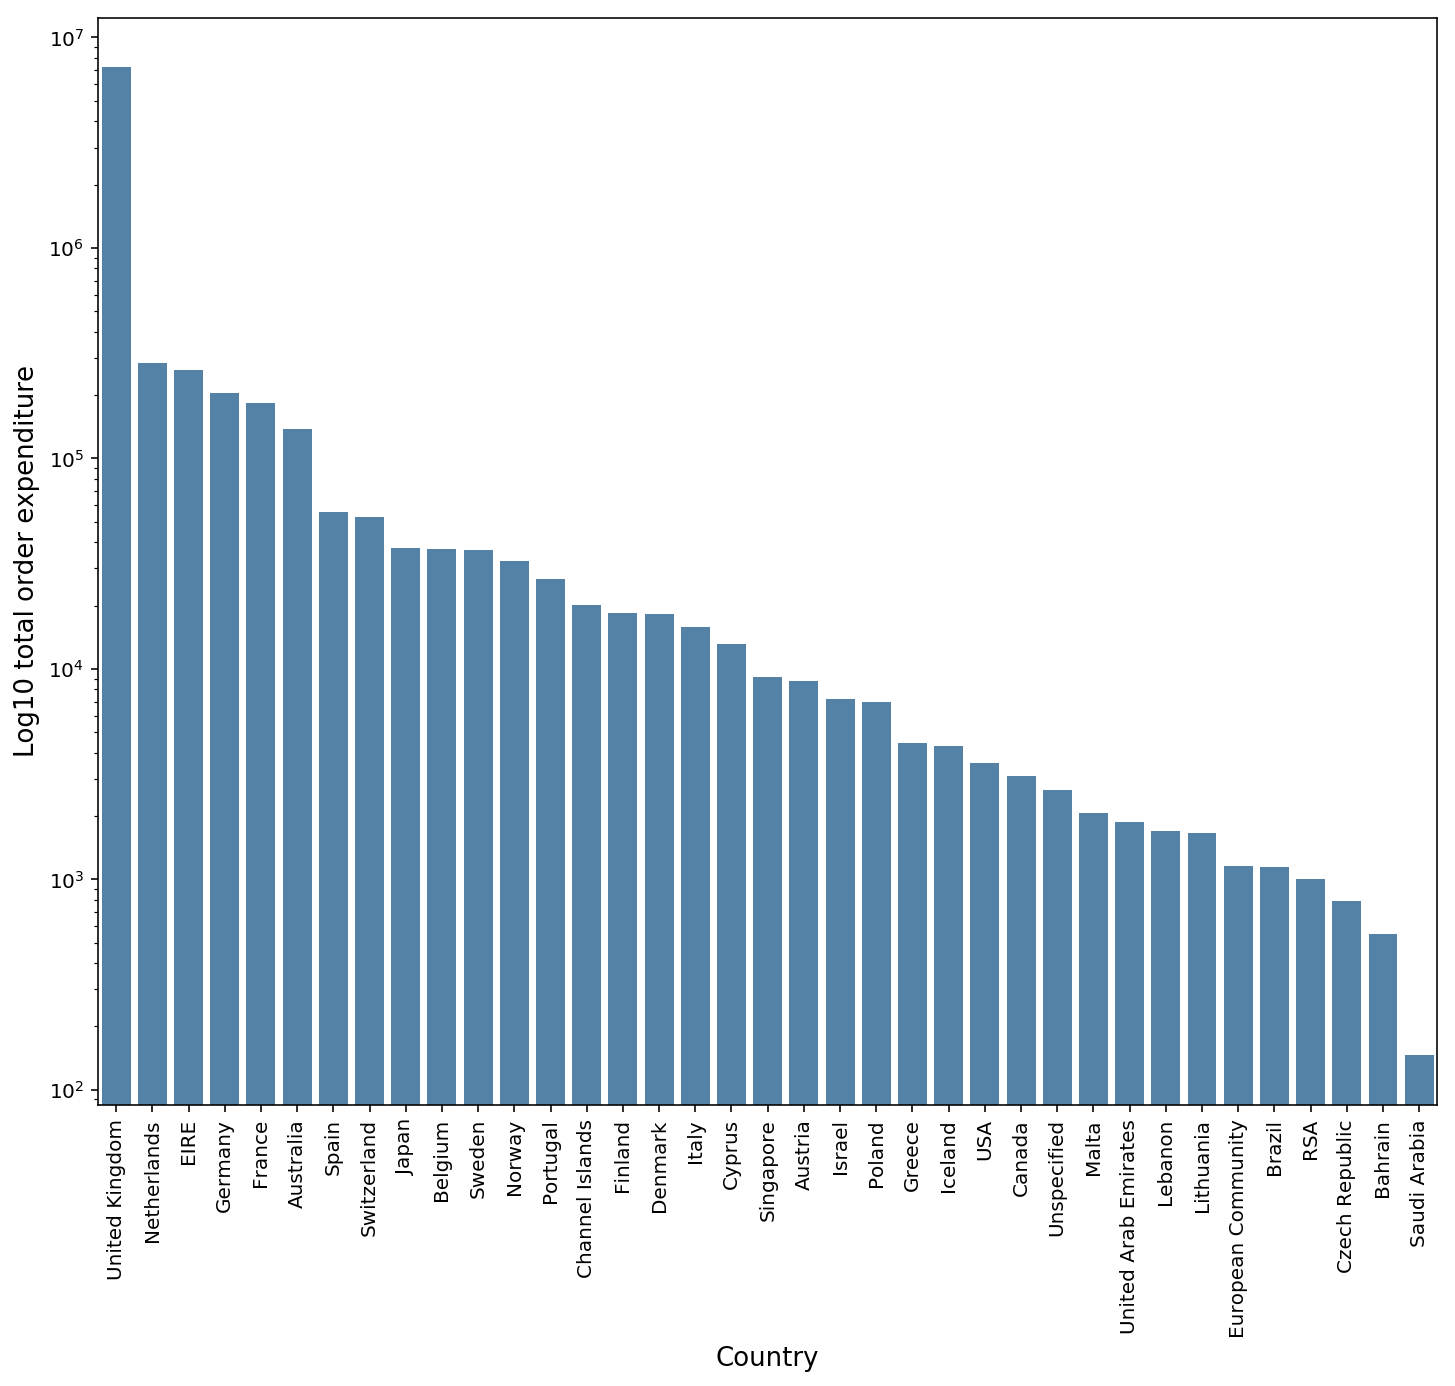

In [95]:
grouped  = data.groupby(['Country']).sum()['total_spend'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color='steelblue')
f.get_axes()[0].set_yscale('log') #I'm using a log scale just for visualisation as the UK dominates the market
plt.ylabel('Log10 total order expenditure', fontsize=13)
plt.xlabel('Country', fontsize=13)
plt.show()

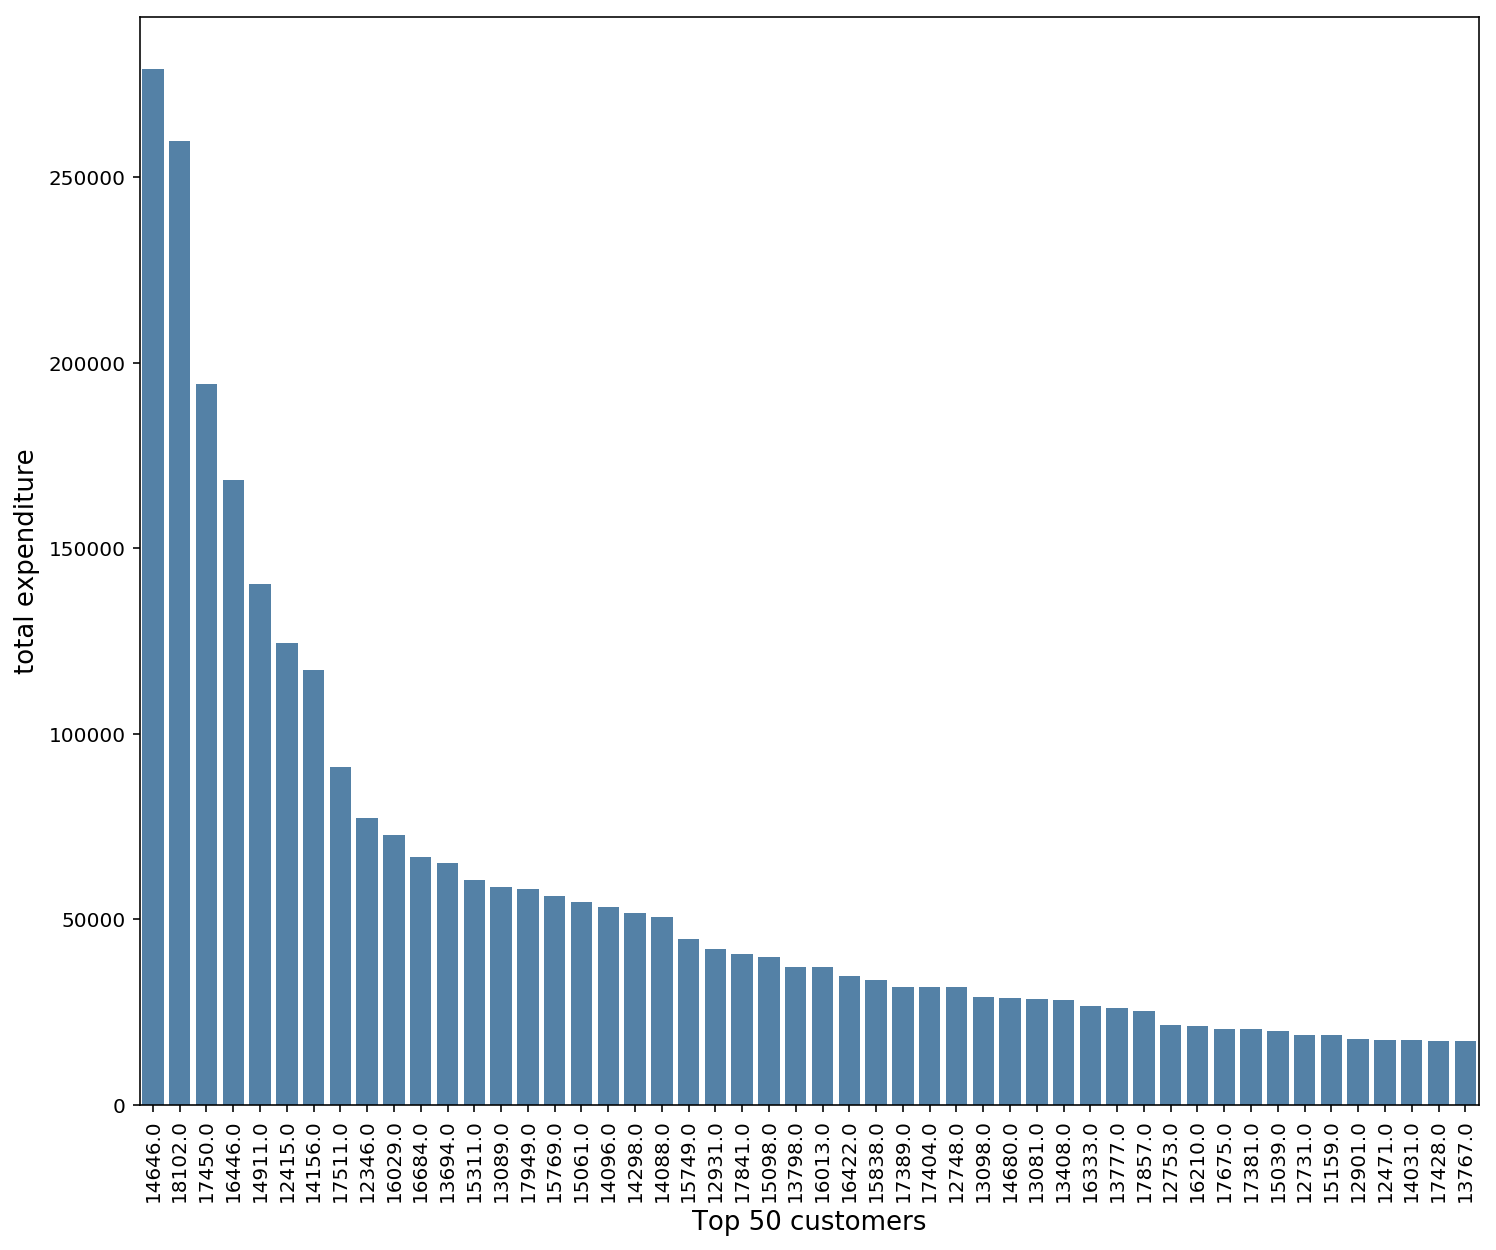

In [177]:
grouped  = data.groupby(['CustomerID']).sum()['total_spend'].sort_values(ascending=False)
grouped_top = pd.DataFrame(grouped.head(50))
grouped_top.reset_index(level=0, inplace=True)
grouped_top.sort_values('CustomerID', ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped_top['CustomerID'], y=grouped_top['total_spend'],order=grouped_top['CustomerID'],color='steelblue')
plt.ylabel('total expenditure', fontsize=13)
plt.xlabel('Top 50 customers', fontsize=13)
plt.show()

In [235]:
top_50 = data[data['CustomerID'].isin(grouped_top['CustomerID'])]
top_50.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.1,16446.0,United Kingdom,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.0,12346.0,United Kingdom,77183.6
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.2,12901.0,United Kingdom,1008.0
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,4/18/2011 13:20,2.1,15749.0,United Kingdom,6539.4
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,1/11/2011 12:55,2.1,15749.0,United Kingdom,6539.4


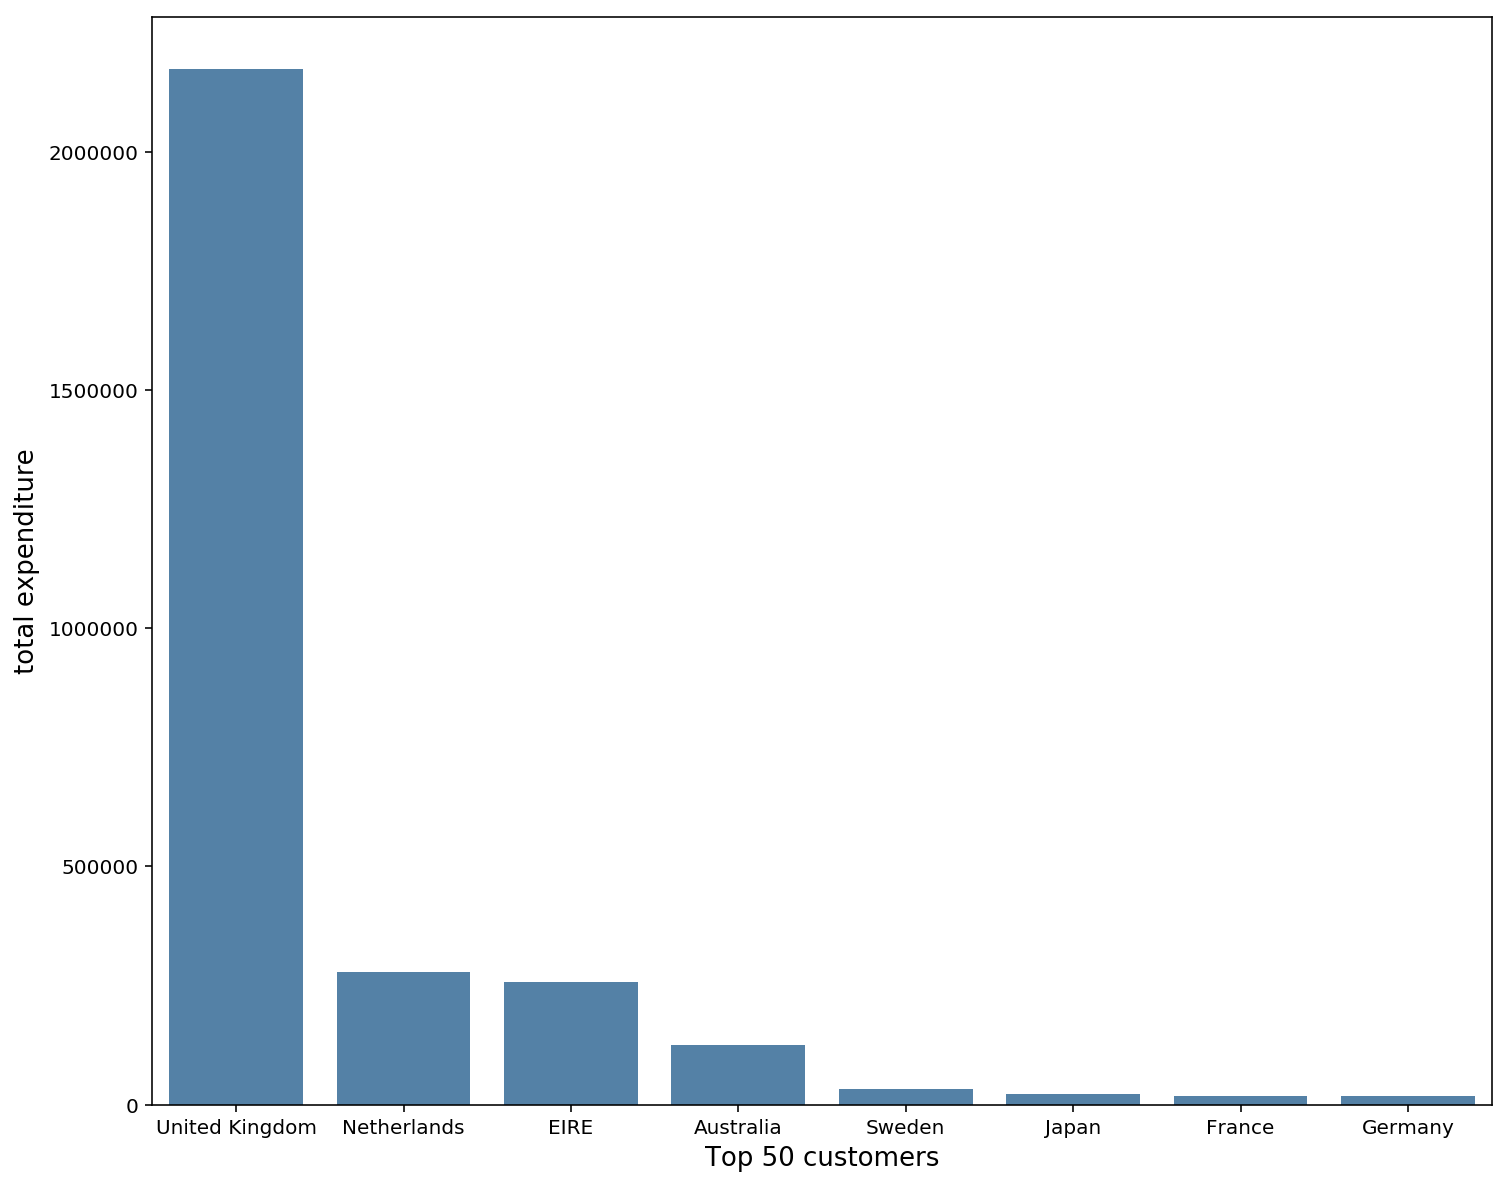

In [179]:
top50_tmp  = top_50.groupby(['Country']).sum()['total_spend'].sort_values(ascending=False)

top50_tmp = pd.DataFrame(top50_tmp)
top50_tmp.reset_index(level=0, inplace=True)
top50_tmp.sort_values('Country', ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='horizontal')
sns.barplot(x=top50_tmp['Country'], y=top50_tmp['total_spend'],order=top50_tmp['Country'],color='steelblue')
plt.ylabel('total expenditure', fontsize=13)
plt.xlabel('Top 50 customers', fontsize=13)
plt.show()

## Clustering

## Addendumm - Apriori modeling

### Generate a basket for each country

In [310]:
basket = (data[data['Country'] == "Netherlands"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))

In [311]:
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,16 PIECE CUTLERY SET PANTRY DESIGN,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 RAFFIA RIBBONS VINTAGE CHRISTMAS,3 STRIPEY MICE FELTCRAFT,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D HEARTS HONEYCOMB PAPER GARLAND,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,6 RIBBONS RUSTIC CHARM,60 CAKE CASES DOLLY GIRL DESIGN,60 CAKE CASES VINTAGE CHRISTMAS,60 TEATIME FAIRY CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,ABC TREASURE BOOK BOX,AIRLINE BAG VINTAGE JET SET RED,AIRLINE BAG VINTAGE JET SET WHITE,ALARM CLOCK BAKELIKE CHOCOLATE,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE IVORY,ALARM CLOCK BAKELIKE PINK,ALARM CLOCK BAKELIKE RED,ALUMINIUM STAMPED HEART,ANGEL DECORATION PAINTED ZINC,APOTHECARY MEASURING JAR,APRON APPLE DELIGHT,ASS FLORAL PRINT MULTI SCREWDRIVER,ASSORTED COLOUR BIRD ORNAMENT,ASSORTED COLOURS SILK FAN,ASSORTED EASTER DECORATIONS BELLS,"ASSORTED FLOWER COLOUR ""LEIS""",ASSORTED TUTTI FRUTTI FOB NOTEBOOK,ASSTD FRUIT+FLOWERS FRIDGE MAGNETS,BAKING MOULD HEART WHITE CHOCOLATE,BAKING MOULD ROSE MILK CHOCOLATE,BAKING SET 9 PIECE RETROSPOT,BAKING SET SPACEBOY DESIGN,...,VINTAGE DONKEY TAIL GAME,VINTAGE EMBOSSED HEART,VINTAGE HEADS AND TAILS CARD GAME,VINTAGE KID DOLLY CARD,WALL ART DOLLY GIRL,WALL ART SPACEBOY,WALL TIDY RETROSPOT,WATERING CAN PINK BUNNY,WHITE BROCANTE SOAP DISH,WHITE HANGING HEART T-LIGHT HOLDER,WHITE SPOT BLUE CERAMIC DRAWER KNOB,WHITE SPOT RED CERAMIC DRAWER KNOB,WHITE WOOD GARDEN PLANT LADDER,WOOD STAMP SET BEST WISHES,WOODEN ADVENT CALENDAR CREAM,WOODEN ADVENT CALENDAR RED,WOODEN CROQUET GARDEN SET,WOODEN OWLS LIGHT GARLAND,WOODEN SCHOOL COLOURING SET,WOODLAND HEIGHT CHART STICKERS,WOODLAND BUNNIES LOLLY MAKERS,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND LARGE BLUE FELT HEART,WOODLAND LARGE PINK FELT HEART,WOODLAND LARGE RED FELT HEART,WOODLAND MINI BACKPACK,WOODLAND MINI RUCKSACK,WOODLAND PARTY BAG + STICKER SET,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL PINK FELT HEART,WOODLAND SMALL RED FELT HEART,WOODLAND STORAGE BOX LARGE,WOODLAND STORAGE BOX SMALL,WRAP VINTAGE DOILEY,WRAP ENGLISH ROSE,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP PAISLEY PARK,WRAP RED APPLES,WRAP WEDDING DAY,YELLOW METAL CHICKEN HEART,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
539491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
539731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,288.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,300.0,0.0,0.0,0

In [312]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [313]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [314]:
frequent_itemsets = apriori(basket_sets, min_support=0.1, use_colnames=True)

In [315]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DOLLY GIRL LUNCH BOX),(ROUND SNACK BOXES SET OF 4 FRUITS),0.2,0.2,0.1,0.5,2.8,0.1,1.6
1,(ROUND SNACK BOXES SET OF 4 FRUITS),(DOLLY GIRL LUNCH BOX),0.2,0.2,0.1,0.6,2.8,0.1,2.2
2,(DOLLY GIRL LUNCH BOX),(ROUND SNACK BOXES SET OF4 WOODLAND),0.2,0.3,0.2,0.7,2.7,0.1,2.7
3,(ROUND SNACK BOXES SET OF4 WOODLAND),(DOLLY GIRL LUNCH BOX),0.3,0.2,0.2,0.6,2.7,0.1,2.1
4,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.2,0.3,0.2,1.0,3.2,0.2,15.4
5,(SPACEBOY LUNCH BOX),(DOLLY GIRL LUNCH BOX),0.3,0.2,0.2,0.8,3.2,0.2,3.1
6,(DOLLY GIRL LUNCH BOX),(STRAWBERRY LUNCH BOX WITH CUTLERY),0.2,0.1,0.1,0.5,3.1,0.1,1.6
7,(STRAWBERRY LUNCH BOX WITH CUTLERY),(DOLLY GIRL LUNCH BOX),0.1,0.2,0.1,0.7,3.1,0.1,2.7
8,(DOLLY GIRL LUNCH BOX),(WOODLAND CHARLOTTE BAG),0.2,0.2,0.1,0.5,2.7,0.1,1.5
9,(WOODLAND CHARLOTTE BAG),(DOLLY GIRL LUNCH BOX),0.2,0.2,0.1,0.6,2.7,0.1,2.0
